In [324]:
import numpy as np
from matplotlib import pyplot as plt
import torch
import torchvision
import cv2
from phasecreator import PLMQuantizerGenerateMask, PLMQuantizerCore, PLMQuantizer

In [325]:
import numpy as np

def gs_algorithm2(Image, iterations: int = 50, mask=None, alpha=0.0, gamma=0.0):
    """
    Implements a variant of the Gerchberg-Saxton algorithm with amplitude correction and mask.
    Args:
        Image: 2D numpy array, target intensity pattern (I in Matlab).
        iterations: number of iterations.
        mask: 2D numpy array, same shape as Image, binary mask (1 for target, 0 for background).
        alpha: amplitude correction parameter.
        gamma: amplitude correction parameter for background.
    Returns:
        pslm_phase: final phase pattern, normalized to [0, 1].
        T_obs: final complex field in image plane.
    """
    s1 = 1
    if isinstance(Image, torch.Tensor):
        s1 = 0
        device = Image.device
        Image = Image.cpu().numpy().astype(np.float32)

    I_tar = np.sqrt(Image)
    random_image = np.random.rand(*Image.shape) * 2 * np.pi
    T_obs = I_tar * np.exp(1j * random_image)

    if mask is None:
        mask = np.ones_like(Image)

    for iter in range(1, iterations + 1):
        alpha_iter = alpha * (iter / iterations)    # zero for no correction
        gamma_iter = gamma * (iter / iterations)    # zero for no correction

        # Amplitude correction
        # Equivalent to T1 = I_tar * mask
        T1 = (I_tar + alpha_iter * (I_tar - np.abs(T_obs))) * mask

        # Equivalent to T2 = 0
        T2 = gamma_iter * (1 - mask) * np.abs(T_obs)

        # Equivalent to T_n = T1 * exp(1j * angle(T_obs))
        T_n = (T1 + T2) * np.exp(1j * np.angle(T_obs))

        # Back to hologram plane
        Hn = np.fft.ifft2(T_n)

        # Set unity magnitude and propagate to image plane
        T_obs = np.fft.fft2(Hn / np.abs(Hn))

    pslm_phase = np.angle(Hn / np.abs(Hn))
    # Normalize between 0 and 1
    #pslm_phase = (np.pi + pslm_phase) / (2 * np.pi)

    if s1 == 0:
        pslm_phase = torch.from_numpy(pslm_phase).to(device)
    return pslm_phase

def gs_algorithm(Image, iterations : int = 50, Source : np.array = None)->np.array:
    s1 = 1
    if isinstance(Image, torch.Tensor):
        s1 = 0
        device = Image.device
        Image = Image.cpu().numpy().astype(np.float32)
    Target = np.sqrt(Image)
    Object = np.exp(1j*np.random.rand(Target.shape[0], Target.shape[1])*2*np.pi)

    phase = lambda p : np.divide(p, np.abs(p))

    if isinstance(Source, type(None)):
        Source = np.ones(shape=Image.shape)

    for _ in range(0, iterations):
        U      = np.fft.ifft2(Object)
        Up     = np.multiply(np.abs(Target)**2, phase(U))
        D      = np.fft.fft2(Up)
        Object = np.multiply(np.abs(Source)**2, phase(D))

        n_unique = quantize(torch.Tensor(np.angle(Object))).unique().numel()
        print(f"INFO: Iteration {_+1}/{iterations} completed. Number of unique values in Object: {n_unique} unique values.")

    if s1 == 0:
        Object = torch.from_numpy(np.angle(Object)).to(device)
    else:
        Object = np.angle(Object)
    return Object


def load_mask_from_file(file_path: str) -> torch.Tensor:
    """
    Load a mask from a file and return it as a tensor.
    The file should contain a 2D array representing the mask.
    """
    data = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
    if data is None:
        raise ValueError(f"Could not read the mask file: {file_path}")
    
    # Convert to tensor and normalize to 0 or 1
    mask = torch.tensor(data, dtype=torch.float32)
    mask = (mask > 0).to(torch.int32)
    return mask

# load the tensor saved
def load_tensor(f):
    t = torch.jit.load(f)
    for _, p in t.named_parameters():
        return p

def quantize(tt : torch.Tensor)->torch.Tensor:
    m_table = torch.Tensor([
        0.0000, 0.0100, 0.0205, 0.0422,
        0.0560, 0.0727, 0.1131, 0.1734,
        0.3426, 0.3707, 0.4228, 0.4916,
        0.5994, 0.6671, 0.7970, 0.9375
    ]).to(tt.device)

    m_levels = m_table.to(tt.dtype).view([1, -1])
    tt = (tt + torch.pi) / (2 * torch.pi)
    flat_x = tt.view([-1])

    diffs = torch.remainder(flat_x.unsqueeze(1) - m_levels + 0.5, 1.0) - 0.5
    indicies = torch.argmin(diffs.abs(),1)

    print(f"INFO: Quantization levels used: {indicies.unique()}")

    return indicies.view_as(tt)

def upscale_blocks(x: torch.Tensor, scale_h: int, scale_w : int) -> torch.Tensor:
    """
    Upscales a 2D tensor x by repeating each 2x2 block in a grid fashion,
    so that the output is (target_size, target_size).
    Assumes target_size is divisible by x.shape[0] and x.shape[1], and by 2.
    """
    h, w = x.shape
    H, W = h * scale_h, w * scale_w

    # Extract 2x2 blocks
    x_blocks = x.unfold(0, 2, 2).unfold(1, 2, 2)  # (h//2, w//2, 2, 2)
    # Repeat each block in a (scale, scale) grid
    x_blocks = x_blocks.repeat_interleave(scale_h, dim=0).repeat_interleave(scale_w, dim=1)  # (h//2*scale, w//2*scale, 2, 2)
    # Rearrange to reconstruct the full array
    out = x_blocks.permute(0,2,1,3).reshape(H, W)
    return out

def upscale_random(x: torch.Tensor, scale_h: int, scale_w: int) -> torch.Tensor:
    pat = upscale_blocks(x, scale_h, scale_w)

    # Generate a random pattern of 0s and 1s at half the size of pat
    h, w = pat.shape
    rand_pattern = torch.randint(0, 2, (h // 2, w // 2), dtype=pat.dtype, device=pat.device)
    # Upscale the random pattern to match pat's size
    rand_pattern_up = rand_pattern.repeat_interleave(2, dim=0).repeat_interleave(2, dim=1)
    # If pat's size is not exactly divisible by 2, crop to match
    rand_pattern_up = rand_pattern_up[:h, :w]
    pat = pat * rand_pattern_up

    return pat

def upscale_zeros (x : torch.Tensor, scale_h: int, scale_w : int) -> torch.Tensor:
    pat  = upscale_blocks(x, scale_h, scale_w)
    
    # Create a mask where each 2x2 block is either fully 0 or 1, in a checkered pattern
    # Create a mask where each (scale_h x scale_w) block alternates between 0 and 1 in a checkerboard pattern,
    # but each block is a solid color (not pixel-wise checkerboard)
    mask = torch.zeros_like(pat, dtype=torch.int32)
    h, w = pat.shape
    # Create grid indices for all rows and columns
    rows = torch.arange(h, device=pat.device).view(-1, 1)
    cols = torch.arange(w, device=pat.device).view(1, -1)
    # Compute block indices for each pixel
    block_rows = rows // scale_h
    block_cols = cols // scale_w
    # Checkerboard pattern: sum of block indices mod 2
    mask[:,:] = ((block_rows + block_cols) % 2).to(mask.dtype)
    # For every two rows, make two rows zero
    mask[::4, :] = 0
    mask[1::4, :] = 0

    # Create a pattern of vertical lines
    # Every other line should be 1
    vertical_lines = torch.zeros_like(mask, dtype=torch.int32)
    vertical_lines[:, ::2] = 1

    vmask = mask * vertical_lines
    rmask = 1 - mask

    rmask = rmask.to(pat.dtype)  # Ensure masks is the same type as pat
    vmask *= (0x00FFFFFF)
    vmask = vmask.to(pat.dtype)

    pat1  = pat  * rmask # Removes certain blocks
    pat2  = pat1 + vmask # Assigns the removed blocks to new pattern

    return pat2

def MEncode_u8Tensor4(tt :torch.Tensor, m_h=1600, m_w=2560, upscale_fn=None) -> torch.Tensor:
    N, input_H, input_W = tt.shape

    shifts = torch.Tensor( 
    [
        (1 << 0),  (1 << 1),
        (1 << 2),  (1 << 3),
        (1 << 4),  (1 << 5),
        (1 << 6),  (1 << 7),
        (1 << 8),  (1 << 9),
        (1 << 10), (1 << 11),
        (1 << 12), (1 << 13),
        (1 << 14), (1 << 15),
        (1 << 16), (1 << 17),
        (1 << 18), (1 << 19),
        (1 << 20), (1 << 21),
        (1 << 22), (1 << 23)
    ]).to(tt.device).to(torch.int32)

    # treat N as a batch dimension, so that it is [N, 1, H, W]
    upscaled = torchvision.transforms.functional.resize(
        tt.unsqueeze(1),
        size=(m_h, m_w), 
        interpolation=torchvision.transforms.InterpolationMode.NEAREST_EXACT, 
        antialias=False
    ).squeeze() # Squeeze to be [N, H, W]

    upscaled = (upscaled > 0).to(torch.int32)  # Convert to binary mask
    shifts_used = shifts[:N].to(tt.device).view(N, 1, 1)
    image = torch.sum(upscaled * shifts_used, 0)
    return image

def MEncode_u8Tensor3(tt : torch.Tensor, m_h=1600,m_w=2560, upscale_fn=upscale_blocks)->torch.Tensor:
    N, input_H, input_W = tt.shape

    masks = torch.Tensor([
        [[1, 0], [1, 0]],  # 0
        [[1, 0], [0, 0]],  # 1
        [[0, 0], [1, 0]],  # 2
        [[1, 0], [1, 1]],  # 3
        [[0, 0], [0, 0]],  # 4
        [[1, 0], [0, 1]],  # 5
        [[0, 0], [1, 1]],  # 6
        [[0, 0], [0, 1]],  # 7
        [[1, 1], [1, 0]],  # 8
        [[1, 1], [0, 0]],  # 9
        [[0, 1], [1, 0]],  #10
        [[0, 1], [0, 0]],  #11
        [[1, 1], [1, 1]],  #12
        [[1, 1], [0, 1]],  #13
        [[0, 1], [1, 1]],  #14
        [[0, 1], [0, 1]]   #15
    ]).to(tt.device)

    shifts = torch.Tensor( 
    [
        (1 << 0),  (1 << 1),
        (1 << 2),  (1 << 3),
        (1 << 4),  (1 << 5),
        (1 << 6),  (1 << 7),
        (1 << 8),  (1 << 9),
        (1 << 10), (1 << 11),
        (1 << 12), (1 << 13),
        (1 << 14), (1 << 15),
        (1 << 16), (1 << 17),
        (1 << 18), (1 << 19),
        (1 << 20), (1 << 21),
        (1 << 22), (1 << 23)
    ]).to(tt.device).to(torch.int32)

    print(tt.unique())
    plane = quantize(tt)
    logical = masks.index_select(0, plane.view([-1]))
    logical = logical.view([N, input_H, input_W, 2, 2])
    logical = logical.permute([0, 1, 3, 2, 4]).contiguous()
    encoded = logical.view([N, input_H * 2, input_W * 2])
    shifts_used = shifts[:N].to(tt.device).view(N, 1, 1)
    encoded = encoded.to(torch.int32)
    image = torch.sum(encoded * shifts_used, 0)

    raw_h, raw_w = image.shape
    scale_h, scale_w = m_h // raw_h, m_w // raw_w
    print(f"INFO: Scale factors for upscaling: {scale_h} (height), {scale_w} (width)")

    #upscaled = image.unsqueeze(0).repeat_interleave(scale_h,1).repeat_interleave(scale_w,2).squeeze(0)
    if scale_h == 1 and scale_w == 1:
        upscaled = image
        print("INFO: No upscaling needed.")
    else:
        upscaled = upscale_fn(image, scale_h, scale_w)
    return upscaled

def MDecode_u8Tensor3(tt : torch.Tensor) -> torch.Tensor:
    masks = torch.Tensor([
        [[1, 0], [1, 0]],  # 0
        [[1, 0], [0, 0]],  # 1
        [[0, 0], [1, 0]],  # 2
        [[1, 0], [1, 1]],  # 3
        [[0, 0], [0, 0]],  # 4
        [[1, 0], [0, 1]],  # 5
        [[0, 0], [1, 1]],  # 6
        [[0, 0], [0, 1]],  # 7
        [[1, 1], [1, 0]],  # 8
        [[1, 1], [0, 0]],  # 9
        [[0, 1], [1, 0]],  #10
        [[0, 1], [0, 0]],  #11
        [[1, 1], [1, 1]],  #12
        [[1, 1], [0, 1]],  #13
        [[0, 1], [1, 1]],  #14
        [[0, 1], [0, 1]]   #15
    ]).to(tt.device)

    H, W = tt.shape
    tt_blocks = tt.unfold(0, 2, 2).unfold(1, 2, 2)  # shape: (H//2, W//2, 2, 2)
    blocks = tt_blocks.contiguous().view(-1, 2, 2)   # (num_blocks, 2, 2)
    masks_flat = masks.view(16, 4)                   # (16, 4)
    blocks_flat = blocks.view(-1, 4)                 # (num_blocks, 4)

    # Compare each block to each mask, get (num_blocks, 16) boolean matrix
    eq = (blocks_flat.unsqueeze(1) == masks_flat.unsqueeze(0))  # (num_blocks, 16, 4)
    matches = eq.all(-1)  # (num_blocks, 16)
    phase_value = matches.float().argmax(1).view(H//2, W//2)
    return phase_value

def quantizer_apply (tt):
    m_table = torch.Tensor([
        0.0000, 0.0100, 0.0205, 0.0422,
        0.0560, 0.0727, 0.1131, 0.1734,
        0.3426, 0.3707, 0.4228, 0.4916,
        0.5994, 0.6671, 0.7970, 0.9375
    ]).to(tt.device)

    return torch.index_select(m_table, 0, tt.reshape(-1)).reshape_as(tt)

def upscale_resize (tt, dims):
    if tt.ndim == 3:
        tt = tt[0,:,:]
    tt=torchvision.transforms.functional.resize(
        tt.unsqueeze(0).unsqueeze(0),
        size=dims, 
        interpolation=torchvision.transforms.InterpolationMode.NEAREST_EXACT, 
        antialias=False
    ).squeeze()
    return tt

def simulate (z1, clamp_value=0.00001,apply_quantization=True,u0=True,u1=True):
    if u0:
        print(f"INFO: Applying quantization to input with shape: {z1.shape}")
        z1  = quantizer_apply(z1.to(torch.int32))
    else:
        if apply_quantization:
            print(f"INFO: Input has shape: {z1.shape}")
            z2, _, _ = PLMQuantizer(z1.cpu().detach().numpy(), mode="Test")
            z1 = torch.Tensor(z2).to(z1.device)
    z1 = torch.exp(-1j * z1)
    if u1:
        z1 = torch.fft.ifftshift(z1)
    z1 = torch.fft.ifft2(z1).abs().pow(2)
    z1 = z1.clamp(0, clamp_value)
    z1 = torch.fft.fftshift(z1)
    return z1

In [323]:
H, W = 800//2, 1280//2
# Genereate the target phase mask
T = torch.zeros(size=(H,W),dtype=torch.float32)
T[:H//8,:W//8] = 1.0    # upper left corner

# Create block pattern on lower right corner
T[400 - 400//8:, :W//8] = 1.0

# Create a circle shifted to the left
r = 30
y, x = torch.meshgrid(torch.arange(H), torch.arange(W), indexing='ij')
T[(x - 160)**2 + (y - 160)**2 < r**2] = 1.0

# Draw a semi-circle on the lower right corner
r = 10
T[(x - H)**2 + (y - W)**2 < r**2] = 1.0

#T = cv2.imread("ti_logo.bmp", cv2.IMREAD_GRAYSCALE)
#if T.ndim >= 3:
#    T = T[:, :, 0]  # Convert to grayscale if needed
#T = cv2.resize(T, (W, H), interpolation=cv2.INTER_LINEAR)
#T = torch.tensor(T, dtype=torch.float32)/np.max(T)
t = gs_algorithm(T, 50)
print(t.unique().numel())
t = t.unsqueeze(0).repeat([20, 1, 1]).to(torch.float32)


INFO: Quantization levels used: tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])
INFO: Iteration 1/50 completed. Number of unique values in Object: 16 unique values.
INFO: Quantization levels used: tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])
INFO: Iteration 2/50 completed. Number of unique values in Object: 16 unique values.
INFO: Quantization levels used: tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])
INFO: Iteration 3/50 completed. Number of unique values in Object: 16 unique values.
INFO: Quantization levels used: tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])
INFO: Iteration 4/50 completed. Number of unique values in Object: 16 unique values.
INFO: Quantization levels used: tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])
INFO: Iteration 5/50 completed. Number of unique values in Object: 16 unique values.
INFO: Quantization levels used: tensor([ 0,  1,  2

tensor([-3.1416, -3.1415, -3.1415,  ...,  3.1415,  3.1415,  3.1416])
INFO: Quantization levels used: tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])
INFO: Scale factors for upscaling: 2 (height), 2 (width)
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])
INFO: Applying quantization to input with shape: torch.Size([800, 1280])
tensor([-3.1416, -3.1415, -3.1415,  ...,  3.1415,  3.1415,  3.1416])
INFO: Quantization levels used: tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])
INFO: Scale factors for upscaling: 2 (height), 2 (width)
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])
INFO: Applying quantization to input with shape: torch.Size([800, 1280])
tensor([ 4, 12])
INFO: Applying quantization to input with shape: torch.Size([800, 1280])


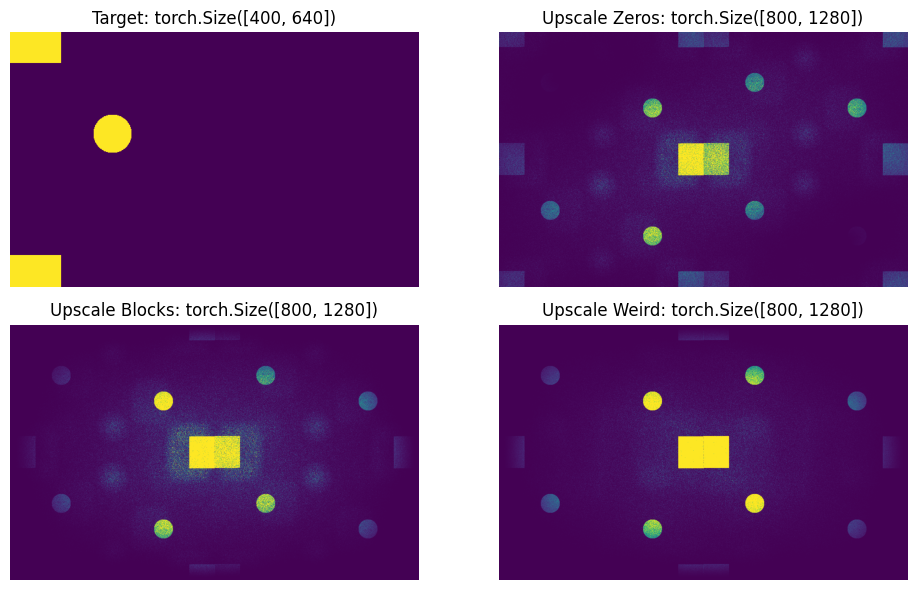

In [326]:
plt.figure(figsize=(12, 6))
plt.subplot(2,2,1)
plt.title(f"Target: {T.shape}")
plt.imshow(T.cpu().detach().numpy())
plt.axis('off')
plt.tight_layout()

z1 = MDecode_u8Tensor3(MEncode_u8Tensor3(t, upscale_fn=upscale_zeros) & 0x1)
print(z1.unique())
z1 = simulate(z1, clamp_value=0.000001,u0=True,u1=False)
plt.subplot(2,2,2)
plt.title(f"Upscale Zeros: {z1.shape}")
plt.imshow(z1.cpu().detach().numpy())
plt.axis('off')
plt.tight_layout()

z2 = MDecode_u8Tensor3(MEncode_u8Tensor3(t, upscale_fn=upscale_blocks) & 0x1)
print(z2.unique())
z2 = simulate(z2, clamp_value=0.000001,u0=True,u1=False)
plt.subplot(2,2,3)
plt.title(f"Upscale Blocks: {z2.shape}")
plt.imshow(z2.cpu().detach().numpy())
plt.axis('off')
plt.tight_layout()

z3 = MDecode_u8Tensor3(MEncode_u8Tensor4(t) & 0x1)
print(z3.unique())
z3 = simulate(z3, clamp_value=0.000001,u0=True,u1=False)
plt.subplot(2,2,4)
plt.title(f"Upscale Weird: {z3.shape}")
plt.imshow(z3.cpu().detach().numpy())
plt.axis('off')
plt.tight_layout()

plt.show()

In [327]:
# Save an image generated by the PLMQuantizerGenerateMask
z3 = ((MEncode_u8Tensor3(t,upscale_fn=upscale_zeros) & 0x1) * 255).to(torch.uint8)
cv2.imwrite('test_result_py.png', z3.cpu().detach().numpy())

tensor([-3.1416, -3.1415, -3.1415,  ...,  3.1415,  3.1415,  3.1416])
INFO: Quantization levels used: tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])
INFO: Scale factors for upscaling: 2 (height), 2 (width)


True

In [328]:
# Create the *weird* pattern
z3 = ((MEncode_u8Tensor4(t) & 0x1) * 255).to(torch.uint8)
print(z3.shape)
cv2.imwrite('test_result_py_weird.png', z3.cpu().detach().numpy())

torch.Size([1600, 2560])


True